In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.io.img_tiles import GoogleTiles


from metpy.calc import reduce_point_density, wind_components
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units
from metpy.io import parse_metar_to_dataframe
from PIL import Image
import numpy as np
import datetime
import xarray as xr
import os

from PythonMETAR import Metar


In [2]:
wxt_global_NEIU = {'conventions': "CF 1.10",
                   'site_ID' : "NEIU",
                  'CAMS_tag' : "CMS-WXT-002",
                  'datastream' : "CMS_wxt536_NEIU_a1",
                  'datalevel' : "a1",
                   "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                   'WSN' : 'W08D',
                  'latitude' : 41.9804526,
                  'longitude' : -87.7196038}

wxt_global_NU = {'conventions': "CF 1.10",
                  'WSN':'W099',
                   'site_ID' : "NU",
                  'CAMS_tag' : "CMS-WXT-005",
                  'datastream' : "CMS_wxt536_NU_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 42.051469749,
                  'longitude' : -87.677667183}

wxt_global_CSU = {'conventions': "CF 1.10",
                  'WSN':'W08E',
                   'site_ID' : "CSU",
                  'CAMS_tag' : "CMS-WXT-003",
                  'datastream' : "CMS_wxt536_CSU_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.71991216,
                  'longitude' : -87.612834722}

#wxt_global_ATMOS = {'conventions': "CF 1.10",
#                  'WSN':'W096',
#                   'site_ID' : "CSU",
#                  'CAMS_tag' : "CMS-WXT-003",
#                  'datastream' : "CMS_wxt536_ATMOS_a1",
#                  'plugin' : "10.31.81.1:5000/local/waggle-wxt536.*",
#                  'datalevel' : "a1",
#                  'latitude' : 41.7016264,
#                  'longitude' : -87.9956515}

wxt_global_UIC = {'conventions': "CF 1.10",
                  'WSN':'W096',
                   'site_ID' : "UIC",
                  'CAMS_tag' : "CMS-WXT-011",
                  'datastream' : "CMS_wxt536_UIC_a1",
                  'plugin' : "10.31.81.1:5000/local/waggle-wxt536.*",
                  'datalevel' : "a1",
                  'latitude' : 41.869407936,
                  'longitude' : -87.645806251}


var_attrs_wxt = {'temperature': {'standard_name' : 'air_temperature',
                       'units' : 'celsius'},
                'humidity': {'standard_name' : 'relative_humidity',
                       'units' : 'percent'},
                'dewpoint': {'standard_name' : 'dew_point_temperature',
                       'units' : 'celsius'},
                'pressure': {'standard_name' : 'air_pressure',
                       'units' : 'hPa'},
                'wind_mean_10s': {'standard_name' : 'wind_speed',
                       'units' : 'celsius'},
                'wind_max_10s': {'standard_name' : 'wind_speed',
                       'units' : 'celsius'},
                'wind_dir_10s': {'standard_name' : 'wind_from_direction',
                       'units' : 'degrees'},
                'rainfall': {'standard_name' : 'precipitation_amount',
                       'units' : 'kg m-2'}}

In [3]:
def ingest_wxt_latest(global_attrs, var_attrs):
    end = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    start = (datetime.datetime.utcnow() - datetime.timedelta(minutes=2)).strftime('%Y-%m-%dT%H:%M:%SZ')
    print(start)
    print(end)
    df_temp = sage_data_client.query(start=start,
                                     end=end, 
                                        filter={
                                            "name" : 'wxt.env.temp|wxt.env.humidity|wxt.env.pressure|wxt.rain.accumulation',
                                            "plugin" : global_attrs['plugin'],
                                            "vsn" : global_attrs['WSN'],
                                            "sensor" : "vaisala-wxt536"
                                        }
    )
    winds = sage_data_client.query(start=start,
                                     end=end, 
                                        filter={
                                            "name" : 'wxt.wind.speed|wxt.wind.direction',
                                            "plugin" : global_attrs['plugin'],
                                            "vsn" : global_attrs['WSN'],
                                            "sensor" : "vaisala-wxt536"
                                        }
    )
    
    hums = df_temp[df_temp['name']=='wxt.env.humidity']
    temps = df_temp[df_temp['name']=='wxt.env.temp']
    pres = df_temp[df_temp['name']=='wxt.env.pressure']
    rain = df_temp[df_temp['name']=='wxt.rain.accumulation']


    npres = len(pres)
    nhum = len(hums)
    ntemps = len(temps)
    nrains = len(rain)
    print(npres, nhum, ntemps, nrains)
    minsamps = min([nhum, ntemps, npres, nrains])

    temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)

    vals = temps.set_index('time')[0:minsamps]
    vals['temperature'] = vals.value.to_numpy()[0:minsamps]
    vals['humidity'] = hums.value.to_numpy()[0:minsamps]
    vals['pressure'] = pres.value.to_numpy()[0:minsamps]
    vals['rainfall'] = rain.value.to_numpy()[0:minsamps]

    direction = winds[winds['name']=='wxt.wind.direction']
    speed = winds[winds['name']=='wxt.wind.speed']

    nspeed = len(speed)
    ndir = len(direction)
    print(nspeed, ndir)
    minsamps = min([nspeed, ndir])

    speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)
    windy = speed.set_index('time')[0:minsamps]
    windy['speed'] = windy.value.to_numpy()[0:minsamps]
    windy['direction'] = direction.value.to_numpy()[0:minsamps]


    winds10mean = windy.resample('10S').mean(numeric_only=True).ffill()
    winds10max = windy.resample('10S').max(numeric_only=True).ffill()
    dp = dewpoint_from_relative_humidity( vals.temperature.to_numpy() * units.degC, 
                                         vals.humidity.to_numpy() * units.percent)

    vals['dewpoint'] = dp
    vals10 = vals.resample('10S').mean(numeric_only=True).ffill() #ffil gets rid of nans due to empty resample periods
    wb = wet_bulb_temperature(vals10.pressure.to_numpy() * units.hPa,
                              vals10.temperature.to_numpy() * units.degC,
                              vals10.dewpoint.to_numpy() * units.degC)

    vals10['wetbulb'] = wb
    vals10['wind_dir_10s'] = winds10mean['direction']
    vals10['wind_mean_10s'] = winds10mean['speed']
    vals10['wind_max_10s'] = winds10max['speed']
    _ = vals10.pop('value')
    
    vals10xr = xr.Dataset.from_dataframe(vals10)
    vals10xr = vals10xr.sortby('time')
    
    vals10xr = vals10xr.assign_attrs(global_attrs)
    
    for varname in var_attrs.keys():
        vals10xr[varname] = vals10xr[varname].assign_attrs(var_attrs[varname])
    
    return vals10xr

In [4]:
Metar('KLOT').metar

'KLOT 271045Z 02008KT 10SM CLR 16/14 A3001 '

In [5]:
kord = parse_metar_to_dataframe(Metar('KORD').metar)
kmdw = parse_metar_to_dataframe(Metar('KMDW').metar)
klot = parse_metar_to_dataframe(Metar('KLOT').metar)


metars = pd.concat([kord, kmdw, klot])
xNU = ingest_wxt_latest(wxt_global_NU, var_attrs_wxt).isel(time=-1)
xNEIU = ingest_wxt_latest(wxt_global_NEIU, var_attrs_wxt).isel(time=-1)
xUIC = ingest_wxt_latest(wxt_global_UIC, var_attrs_wxt).isel(time=-1)

#xNEIU = ingest_wxt_latest(wxt_global_NEIU, var_attrs_wxt).isel(time=-1)

xNU['latitude'] = xNU.attrs['latitude']
xNU['longitude'] = xNU.attrs['longitude']
xNU['site'] = 'NU'
xNEIU['latitude'] = xNEIU.attrs['latitude']
xNEIU['longitude'] = xNEIU.attrs['longitude']
xNEIU['site'] = 'NEIU'

xUIC['latitude'] = xUIC.attrs['latitude']
xUIC['longitude'] = xUIC.attrs['longitude']
xUIC['site'] = 'UIC'


mrg = xr.concat([xNU, xNEIU, xUIC], dim='site')
data = mrg.to_dataframe()

2024-06-27T11:19:32Z
2024-06-27T11:21:32Z
1477 1477 1477 1477
1477 1477
2024-06-27T11:19:33Z
2024-06-27T11:21:33Z


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)
/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)


157 157 157 157
157 157
2024-06-27T11:19:34Z
2024-06-27T11:21:34Z


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)
/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)


1368 1368 1368 1368
1368 1368


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)
/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_36612/2842389473.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)


In [6]:
metars

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KORD,KORD,41.98,-87.93,200,2024-06-27 10:51:00,20,7.0,NaN,16093.44,NaN,...,17.0,13.0,30.00,0,0,0,AO2 SLP155 T01670128,1016.00,-2.394141,-6.577848
KMDW,KMDW,41.78,-87.75,188,2024-06-27 10:53:00,30,8.0,NaN,16093.44,NaN,...,18.0,12.0,30.00,0,0,0,AO2 SLP150 T01780122,1015.94,-4.000000,-6.928203
KLOT,KLOT,41.60,-88.10,205,2024-06-27 10:45:00,20,8.0,NaN,16093.44,NaN,...,16.0,14.0,30.01,0,0,0,,1016.42,-2.736161,-7.517541


In [7]:
data['station_id'] = ['NU', 'NEIU', 'UIC']

In [8]:
# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)

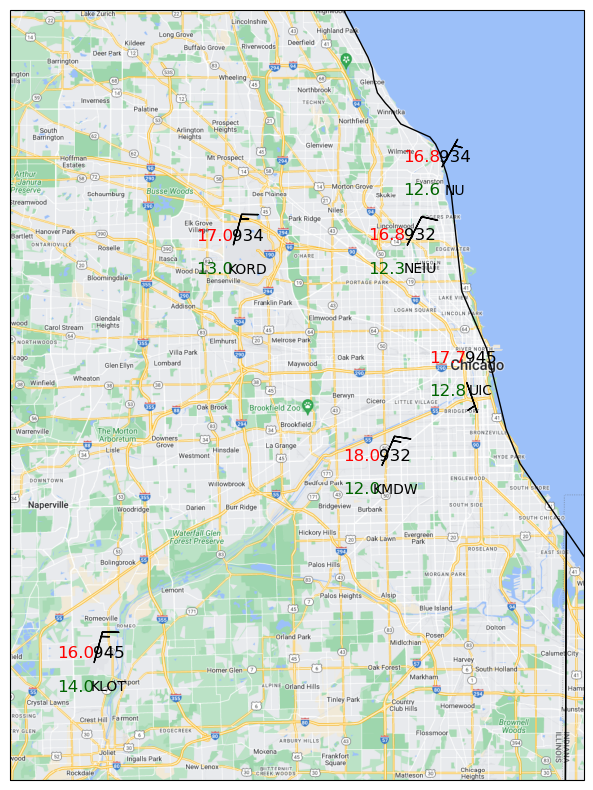

In [9]:
fig = plt.figure(figsize=(20, 10))
tiler = GoogleTiles(style="street")
mercator = tiler.crs
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=mercator)


# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "10m"),
#              ec="red", fc="yellow", lw=2, alpha=0.4)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 11)

# Set plot bounds
ax.set_extent((-88.2, -87.5, 41.5, 42.2))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

stationplot.plot_parameter('NW', data['temperature'].values, color='red', formatter = '0.1f')
stationplot.plot_parameter('SW', data['dewpoint'].values,
                           color='darkgreen', formatter = '0.1f')

stationplot.plot_parameter('NE', data['pressure'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

ew, nw = wind_components(data['wind_mean_10s'].values * units.meter_per_second , 
                                data['wind_dir_10s'].values * units.degrees_north)

stationplot.plot_barb(ew.to(units.kilometer_per_hour), nw.to(units.kilometer_per_hour))

stationplot.plot_text('SE', data['station_id'].values, fontsize=10)



stationplot_metars = StationPlot(ax, metars['longitude'].values, metars['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

stationplot_metars.plot_parameter('NW', metars['air_temperature'].values, color='red', formatter = '0.1f')
stationplot_metars.plot_parameter('SW', metars['dew_point_temperature'].values,
                           color='darkgreen', formatter = '0.1f')

stationplot_metars.plot_parameter('NE', data['pressure'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])


ew, nw = wind_components(metars['wind_speed'].values * units.knot , 
                                metars['wind_direction'].values * units.degrees_north)


stationplot_metars.plot_barb(ew.to(units.kilometer_per_hour), nw.to(units.kilometer_per_hour))
stationplot_metars.plot_text('SE', metars['station_id'].values, fontsize=10)

plt.savefig('/Users/scollis/latest_CROCUS.png')